# Part 2.1 Support Vector Machine
**과목명:  응용데이터애널리틱스 (Applied Data Analytics)** \\
**학수번호:  INE4108** \\
**교강사:  송재욱 교수 (산업공학과)** \\
 \\
***

### 2.1.0. Environmental Set-up & Data Loading

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME =  'ADX/'

assert FOLDERNAME is not None, 'ERROR'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'


In [ ]:
data_ = pd.read_csv('./ADX/Data_CreditCard/creditcard.csv', encoding ='cp949', index_col = 0)
columns_ = data_.columns

In [ ]:
data_.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
190368,128803.0,-2.272473,2.935226,-4.871394,2.419012,-1.513022,-0.480625,-2.126136,1.883507,-1.297262,-5.487425,2.969240,-3.055405,-0.316544,-7.862809,-2.202800,-1.932316,-2.284748,0.324787,-0.183181,-0.031085,0.718504,0.893850,-0.031632,0.322913,-0.058406,-0.411649,0.573803,0.176067,175.90,1
9179,13126.0,-2.880042,5.225442,-11.063330,6.689951,-5.759924,-2.244031,-11.199975,4.014722,-3.429304,-11.561950,10.446847,-15.479052,0.734442,-13.883779,0.821440,-11.911483,-18.103004,-6.837835,3.126929,1.191444,2.002883,0.351102,0.795255,-0.778379,-1.646815,0.487539,1.427713,0.583172,1.00,1
42700,41204.0,-8.440284,6.147653,-11.683706,6.702780,-8.155839,-3.716264,-12.407313,5.626571,-6.232161,-13.386683,7.605559,-13.351815,0.827050,-14.979477,1.532813,-11.771497,-20.299217,-7.609110,3.809136,0.520732,2.192855,-0.282597,0.008068,0.403858,-0.018788,0.522722,0.792691,0.067790,30.26,1
239501,150139.0,-6.682832,-2.714268,-5.774530,1.449792,-0.661836,-1.148650,0.849686,0.433427,-1.315646,-2.796332,-0.448794,-2.562602,0.243483,-1.181669,0.004373,-2.302596,-4.446192,-1.710463,0.982729,-1.928527,0.220526,1.187013,0.335821,0.215683,0.803110,0.044033,-0.054988,0.082337,237.26,1
154286,101051.0,-1.465316,-1.093377,-0.059768,1.064785,11.095089,-5.430971,-9.378025,-0.446456,1.992110,1.785922,1.368585,-1.471697,-0.724759,3.442422,-0.957403,-1.626129,1.418215,-1.417917,-1.651766,-1.457610,1.160623,-1.259697,-15.981649,-0.883670,-3.536716,-0.592965,0.675525,0.424849,0.92,1


In [ ]:
data_.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

### 2.1.1. Kernel Function

Kernel function 구현

In [ ]:
#################################################################################
# TODO: Kernel function Using Matrix Form  
# - Linear kernel 구현 (dot product 사용)
#################################################################################

def Kernel_(x, y, params = 0, type_ = 'default') :

    if type_ == 'rbf' :
        Kernel = np.exp(- (np.sum(x **2, axis = 1).reshape(-1,1) + np.sum(y **2, axis = 1).reshape(1,-1) - 2 * x @ y.T)* params)
    elif type_ == 'default' :
        Kernel = np.dot(x, y.T)
    return Kernel

    ######### type이 default일 경우 Kernel이 Linear이도록 구현 (elif 사용 + 위 rbf 구조 활용)
    

### 2.1.2. Linear Kernel (soft-margin) SVM using cvxopt solver

Convex Optimization Documentation:  [Link](https://cvxopt.org/userguide/coneprog.html)

---

Soft-margin SVM의 dual problem을 Convex optimization Solver를 이용하여 Alpha를 구하고, 이를 토대로 w와 b를 구한다.

**Kernel : default(dot product)**

In [ ]:
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

def Convolution(pred, real) :
    pred = np.array(pred)
    y = np.array(real)
    TP = np.sum((pred == 1) & (y == 1))
    FP = np.sum((pred == 1) & (y != 1))
    FN = np.sum((pred != 1) & (y == 1))
    TN = np.sum((pred != 1) & (y != 1))
    return TP, FP, FN, TN
    
def precision_recall(X) :
  TP,FP,FN,TN = X
  return TP / (TP + FP), TP / (TP + FN)

def Minmax_(X) :
    X = np.array(X)
    return (X - X.min(axis = 0)) / (X.max(axis= 0) - X.min(axis = 0)), X.max(axis =0) , X.min(axis =0)

def Standar_(X) :
    X = np.array(X)
    return (X - X.mean(axis =0)) / X.std(axis = 0), X.mean(axis =0), X.std(axis = 0)

-------------------------------------
**Question: 상기 4개 함수의 목적과 의미를 서술하세요.**

-------------------------------------

Answer:

1. convolution 함수


    - 목적: 예측 분류 결과와 실제 label을 비교하여 confusion matrix 반환
    - 의미: 해당 지표를 활용해 분류가 잘 되었는지를 다양한 측면에서 해석 가능

2. precision_recall 함수


    - 목적: 데이터의 정밀도와 재현도를 반환. 
       정밀도(Precision)는 TP / (TP + FP), 모델이 True라고 분류한 것 중에서 실제 True인 것의 비율.
       재현율(Recall)은 TP / (TP + FN), 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율.
    - 의미: FP과 FN는 각각 Type 1, 2 error로 해석할 수 있으므로 precision과 recall은 trade-off 관계에 있다. 
       따라서 두가지 지표를 함께 늘리기는 어려우며 두 값 모두 높은 모델은 성능이 좋다고 볼 수 있다.

3. Minmax_ 함수


    - 목적: 최소-최대 정규화, 모든 feature에 대해 각각의 최소값 0, 최대값 1로, 그리고 다른 값들은 0과 1 사이의 값으로 변환. 
    - 의미: 데이터 스케일의 영향을 없애주기 위해 사용. 표준화와 비교하여 0과 1 사이에 데이터 값이 정규화된다는 장점이 있음

4. Standar_ 함수


    - 목적: 표준화. 모든 feature에 대해 값들을 0의 평균, 1의 표준편차를 갖도록 변환.
    - 의미: 데이터 스케일의 영향을 없애주기 위해 사용. 최대-최소 정규화에 비해 이상치에 덜 민감하다는 장점이 있음.


In [ ]:
#Initializing values and computing H matrix. Note the 1. to force to float type
C = 10  # 여기 C는 hyperparameter이므로 변형 가능함 (이번에는 10으로 고정하고 진행)
X = Standar_(np.array(data_[columns_[:-1]]))[0]
y = np.array(data_[columns_[-1]])* 1.

y = y.reshape(-1,1) 
m,n = X.shape

In [ ]:
# SVM Solver 
# 1. def Kernel_ 생성, default = dot product                                    
# 2. 위 block에서 X, y, c가 정의되었을 때, H, P, q, G, h, A, b를 numpy array 형식으로 작성      
# 3. Kernel이 dot product인 경우 w와 b를 모두 출력 가능                              
# (** support vector는 0 < alpha_i< C )                                   


H = Kernel_(X, X) * 1.
H *= y@y.T

P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(np.vstack((-np.eye(m),np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -5.8129e+02 -1.0298e+05  4e+05  1e+00  6e-13
 1: -4.2201e+02 -5.1005e+04  1e+05  3e-01  6e-13
 2: -2.6726e+02 -2.0455e+04  4e+04  9e-02  4e-13
 3: -1.8589e+02 -1.0262e+04  2e+04  4e-02  3e-13
 4: -9.6012e+01 -5.7119e+03  8e+03  1e-02  3e-13
 5: -8.7623e+01 -2.4313e+03  3e+03  4e-03  2e-13
 6: -1.3650e+02 -1.2150e+03  1e+03  1e-03  2e-13
 7: -1.7550e+02 -6.5484e+02  5e+02  3e-04  2e-13
 8: -1.9086e+02 -5.3416e+02  3e+02  1e-04  2e-13
 9: -2.0543e+02 -4.3445e+02  2e+02  5e-05  2e-13
10: -2.1462e+02 -4.0309e+02  2e+02  3e-05  2e-13
11: -2.2073e+02 -3.7532e+02  2e+02  2e-05  2e-13
12: -2.3983e+02 -3.3847e+02  1e+02  5e-06  2e-13
13: -2.4876e+02 -3.1464e+02  7e+01  3e-06  2e-13
14: -2.4776e+02 -3.1241e+02  6e+01  2e-06  2e-13
15: -2.5088e+02 -3.0203e+02  5e+01  2e-06  2e-13
16: -2.5455e+02 -2.9130e+02  4e+01  9e-07  3e-13
17: -2.5610e+02 -2.8591e+02  3e+01  6e-07  2e-13
18: -2.6030e+02 -2.7701e+02  2e+01  1e-07  3e-13
19: -2.6374e+02 -2.71

-------------------------------------
**Question: P, q, G, h, A, b가 각각 의미하는 바를 cvxopt_solver와 Soft-margin SVM의 Dual 식과 연관하여 서술하세요.**

(Hint:  각각의 정의는 Soft-margin SVM의 Dual 식과 미세한 차이가 존재함. 그 이유에 대해서도 반드시 고민하여 함께 서술할 것.)

-------------------------------------

Answer:

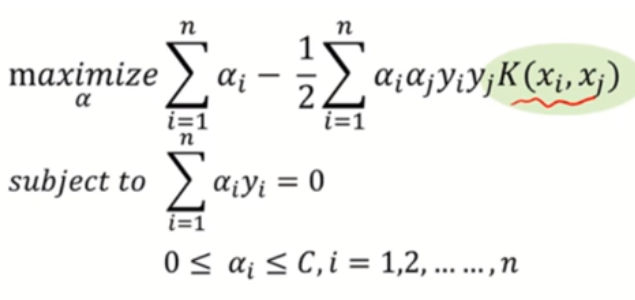

SVM의 원래 문제 ( Maximize 문제)

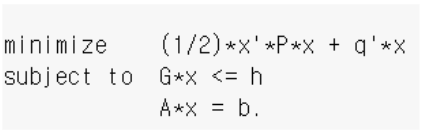

Convex Optimizer Solver의 Document ( Minizize로 구현되어 있음)

Max를 Min으로 바꾸어서 구현해야하는 상태

P = 목적식의 2차항 계수 , y_i * y_j K(x_i, x_j) 부분 , 구현된 패키지에서는 min 이므로 위의 max에 -를 취해주면 그대로 사용하면 된다. 

q = 목적식의 1차항 계수 , 알파에 대해 시그한 한 term, max문제를 min문제로 바꾸면서 -를 취해주었기 때문에 -np.ones((m, 1))으로 구현

G = unequal contsraint의  term의 계수.
/ 두 부등식을 쪼개어서 2000개의 부등식

h = uneqal constraint의 우변(C)
 / 두 부등식을 쪼개어서 위의 1000개는 - alpha <= 0
아래의 1000개는 alpha <= C 를 의미

A = equal constraint의 alpha_i의 계수 

b = equal constraint의 우변


In [ ]:
#Results

w = ((y * alphas).T @ X).reshape(-1,1)
S = ((alphas > 1e-4) & (alphas < C-1e-4)).flatten()
b = y[S] - np.sum(Kernel_(X, X[S], type_ = 'default')* y * alphas , axis = 0).reshape(-1,1)

print('Alphas = ',alphas[(alphas > 1e-4) & (alphas < C-1e-4)])
print('')
print('w = ', w.flatten())
print('')
print('b = ', np.mean(b))
print('')
print("support vector : ", np.array(range(m))[S])

Alphas =  [0.93391227 0.73167443 9.07800516 9.43345917 0.20215315 4.75997645
 0.04898054 0.9437631  1.86790295 0.47439464 3.11719337 4.15402778
 0.69513092 6.68553408 2.71619507 0.50311204 3.00745515 0.39546727
 7.15310869 9.09066684 7.95663166 3.62974161 5.19419453 1.73525492
 7.67969291 1.70451724 0.97884382 3.32793671 1.40845859 1.15099831]

w =  [-0.16485571  1.51871316 -0.0486063   0.70754104  1.13478361  0.91858635
 -0.40166639 -1.39914304 -0.99450461 -1.44138494 -2.46660068  0.33934072
 -1.34516895 -0.15421702 -1.75442775 -0.11663225 -0.85224686 -1.15180705
 -0.59394569  0.02060396 -1.26201162  0.11997614  0.12094323  0.17223573
  0.18050741 -0.24004218 -0.3830853  -1.02168134  0.42591414  1.06549356]

b =  -1.18705524384244

support vector :  [  4  23  48  65  96 120 143 146 283 295 310 313 318 339 352 445 462 470
 516 538 565 610 659 671 743 748 757 826 836 870]


-------------------------------------
**Question: Alphas, w, b, support vector가 의미하는 바를 각각 수리적 관점에서 서술하세요.**

-------------------------------------

Answer:

Alphas : nonlinear svm에서 구한 알파값의 해 (Lagragian dual variable)

w : discriminant function(hyperplane)의 coefficient 

b : discriminant function(hyperplane)의 상수값

support vector : plus-plane과 minus-plane 사이에 위치한 x값

In [ ]:
# Scikit Learn 라이브러리 내 SVM 적용

from sklearn.svm import SVC
clf = SVC(C = 10, kernel = 'linear', tol = 1e-4)
clf.fit(X, y.ravel()) 

print('Coefficients of the support vector in the decision function = ')
print(np.abs(clf.dual_coef_))
print('')
print('w = ',clf.coef_)
print('')
print('b = ',clf.intercept_)
print('')
print('support vector = ', clf.support_)

Coefficients of the support vector in the decision function = 
[[ 4.76053288  0.04877752  0.94363358  1.86788291  0.47538973  3.11633477
   4.15500481  0.69446258 10.          6.68500901  2.71582538 10.
   0.50111777  3.00602632  0.39551835  7.15258254  9.09066715  7.95861301
  10.          3.6321535   5.19350716  1.73479971 10.          7.68069554
   1.70457096  0.97634427  3.33081776  1.40836349 10.          1.15160154
  10.          0.93387611 10.         10.          0.73093066 10.
  10.         10.         10.         10.         10.         10.
   9.07774104 10.         10.          9.43550717  0.20217726 10.        ]]

w =  [[-0.16495046  1.51899825 -0.04860233  0.70741117  1.13462223  0.91881651
  -0.40155428 -1.39929576 -0.99434525 -1.44162743 -2.46643116  0.33928996
  -1.3454202  -0.15422616 -1.75472903 -0.11669532 -0.85239246 -1.15203145
  -0.59380786  0.02062068 -1.26220233  0.12003925  0.12096868  0.17228328
   0.18055367 -0.24014483 -0.38303983 -1.0216802   0.42593406  1.

In [ ]:
# Classification based on Linear Kernel SVM 
# - alpha, b를 이용하여 예측값 도출 (np.sign, Kernel 활용)                     #
pred_sol = np.sign(np.sum(Kernel_(X, X  ,type_ = 'default')* y * alphas , axis = 0).reshape(-1,1) + b[0])

# Scikit Learn 결과 와의 비교
np.sum(clf.predict(X) - pred_sol.flatten())

0.0

In [ ]:
precision_recall(Convolution(pred_sol,y))

(0.9891304347826086, 0.91)

-------------------------------------

**Question: 상기 classification performance의 의미를 서술하세요.**

-------------------------------------

Answer:


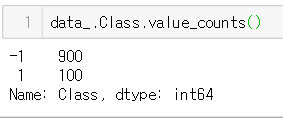


linear하게 서포트벡터로 분류해낸 pred 결과와 실제 real label에 대한 정밀도와 재현도이다.

현재 class -1과 1이 9:1로 imbalance하게 되어있는 상태에서는 class 1 ( ex) default )를 잘 맞추는 것이 매우중요하다.

현재 precesion_recall 함수는 class 1을 true라고 설정되어 있는 상태이다.

데이터가 imbalance하고, 두 가지 지표가 trade-off관계 임에도 불구하고 정밀도가 0.98정도이고 재현도가 0.91으로 나와 모델이 좋은 성능을 보이고 있다고 해석할 수 있다.



### 2.1.3. Gaussian (RBF) Kernel SVM using cvxopt solver

Kernel로 미리 정의해 둔 RBF 사용하여 직접 구현할 것

In [ ]:
#################################################################################
# TODO: SVM Solver Kernel = 'rbf'                                 
# 1. Linear Kernel과 동일하게 H matrix 계산을 위한 기초값 Initialization
# 2. def Kernel_ 작성, default = rbf product                      
# 3. H, P, q, G, h, A, b를 numpy array 형식으로 작성 (Gamma = 2로 설정)
# 4. Alphas, S, b 결과 출력 (Kernel이 rbf인 경우 b를 출력 (w는 출력 불가)
#################################################################################

def Kernel_(x, y, params = 2, type_ = 'default') :

    if type_ == 'default' :
        Kernel = np.exp(- (np.sum(x **2, axis = 1).reshape(-1,1) + np.sum(y **2, axis = 1).reshape(1,-1) - 2 * x @ y.T)* params)
    return Kernel

#Initializing values and computing H matrix. Note the 1. to force to float type
C = 10  # 여기 C는 hyperparameter이므로 변형 가능함 (이번에는 10으로 고정하고 진행)
X = Standar_(np.array(data_[columns_[:-1]]))[0]
y = np.array(data_[columns_[-1]])* 1.

y = y.reshape(-1,1) 
m,n = X.shape

H = Kernel_(X, X, params = 2, type_='default') * 1.
H *= y@y.T

P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(np.vstack((-np.eye(m),np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

#Results
S = ((alphas > 1e-4) & (alphas < C-1e-4)).flatten()
b = y[S] - np.sum(Kernel_(X, X[S], params=2, type_ = 'default')* y * alphas , axis = 0).reshape(-1,1)

print('Alphas = ',alphas[(alphas > 1e-4) & (alphas < C-1e-4)])
print('')
print('b = ', np.mean(b))
print('')
print("support vector : ", np.array(range(m))[S])

     pcost       dcost       gap    pres   dres
 0:  1.1233e+03 -2.1902e+04  2e+04  5e-13  5e-15
 1:  4.0674e+02 -3.1858e+03  4e+03  2e-13  5e-15
 2: -1.3134e+02 -4.7529e+02  3e+02  5e-13  1e-15
 3: -1.7599e+02 -2.0145e+02  3e+01  3e-13  3e-16
 4: -1.7673e+02 -1.7721e+02  5e-01  8e-14  8e-17
 5: -1.7674e+02 -1.7678e+02  4e-02  3e-13  7e-17
 6: -1.7674e+02 -1.7674e+02  2e-03  3e-13  6e-17
 7: -1.7674e+02 -1.7674e+02  4e-05  3e-14  7e-17
Optimal solution found.
Alphas =  [1.79257312e+00 1.79257312e+00 1.79257311e+00 1.79257312e+00
 1.79257312e+00 1.79257312e+00 1.79257312e+00 1.79257312e+00
 1.79257312e+00 1.79256632e+00 1.79257312e+00 1.79257312e+00
 1.79353230e+00 1.17711994e+00 1.79257312e+00 1.79257312e+00
 1.79257312e+00 1.79257312e+00 1.79257312e+00 1.79257312e+00
 1.74407303e+00 1.79256950e+00 1.79257312e+00 1.79257312e+00
 1.79257312e+00 1.79257312e+00 1.74407303e+00 1.79257276e+00
 1.79257312e+00 1.79258873e+00 1.48827655e+00 1.79304876e+00
 1.79301497e+00 1.79257314e+00 1.79256

In [ ]:
# - alpha, b를 이용하여 예측값 도출 (np.sign, Kernel 활용)                     #
rbf_pred_sol = np.sign(np.sum(Kernel_(X, X, params=2  ,type_ = 'default')* y * alphas , axis = 0).reshape(-1,1) + b[0])

In [ ]:
#################################################################################
# TODO: Scikit Learn으로 Gaussian Kernel SVM 구현
# - 상기 구현과 같은 parameter 넣을 것 (C와 Gamma)
# - 그 외 input은 Linear Kernel SVM과 동일하게 적용
#################################################################################
from sklearn.svm import SVC
svm = SVC(C = 10, kernel = 'rbf', gamma = 2, tol = 1e-5)
svm.fit(X, y.ravel())

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=1e-05,
    verbose=False)

In [ ]:
###############################################################################################
# TODO: Classification 시행 및 Scikit learn과의 비교 시행 (차이가 존재하지 않는 것을 확인할 것)
###############################################################################################
np.sum(svm.predict(X) - rbf_pred_sol.flatten())

0.0

In [ ]:
#################################################################################
# TODO: 직접 구현 한 Gaussian Kernel SVM의 Classification Performance 계산
#################################################################################

# Standardization을 통한 scale
precision_recall(Convolution(rbf_pred_sol,y))

(1.0, 1.0)

-------------------------------------
**Question: Linear와 Gaussian Kernel SVM의 Performance 차이를 논하세요.**

-------------------------------------

Answer: 


Linear와 Gaussian Kernel SVM의 정밀도, 재현도를 비교하면 각 (0.989, 0.91)과 (1.0, 1.0)로써 Gaussian Kernel이 더 좋은 성능을 보이고 있다. 이는 Gaussian Kernel이 데이터가 가지고 있는 비선형적인 특성을 더 잘 잡아내어 분류해내었다고 볼 수 있다.

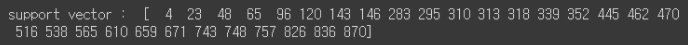

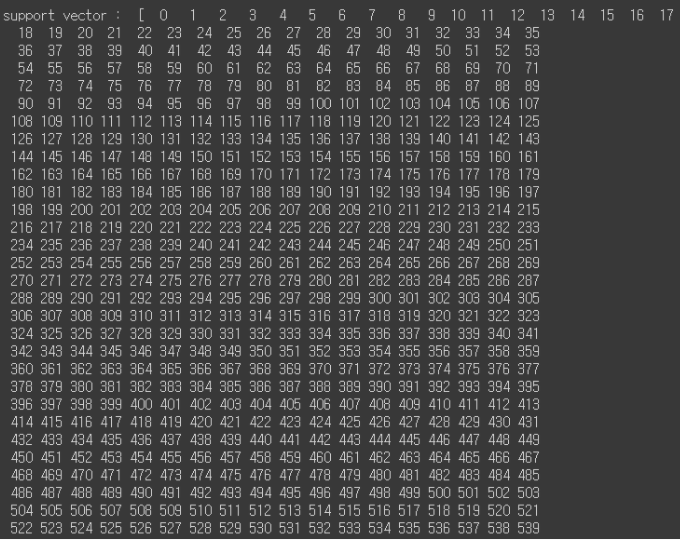

linear kernel 같은 경우는 dimension에 맞추어서 hyperplane을 결정하면 되기 때문에 필요한 support vector의 수가 적다
그러나 gaussian kernel을 이용한경우 비선형적인 decision boundary를 형성하고 있고 이러한 모델은 복잡도가 높고 필요한 support vector의 수가 훨씬 많이 필요하다
Gaussian Kernel이 데이터에 overfitting되었을 가능성도 배제할 수 없기에 현재 상태로 주어진 데이터에 대하여 Gaussian Kernel이 더 적합하다고 단정지을 수는 없으며, 추후에 validation, test set을 이용하여 추가적인 검증을 해야할 필요가 있다고 판단된다.

